In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm_notebook as tqdm


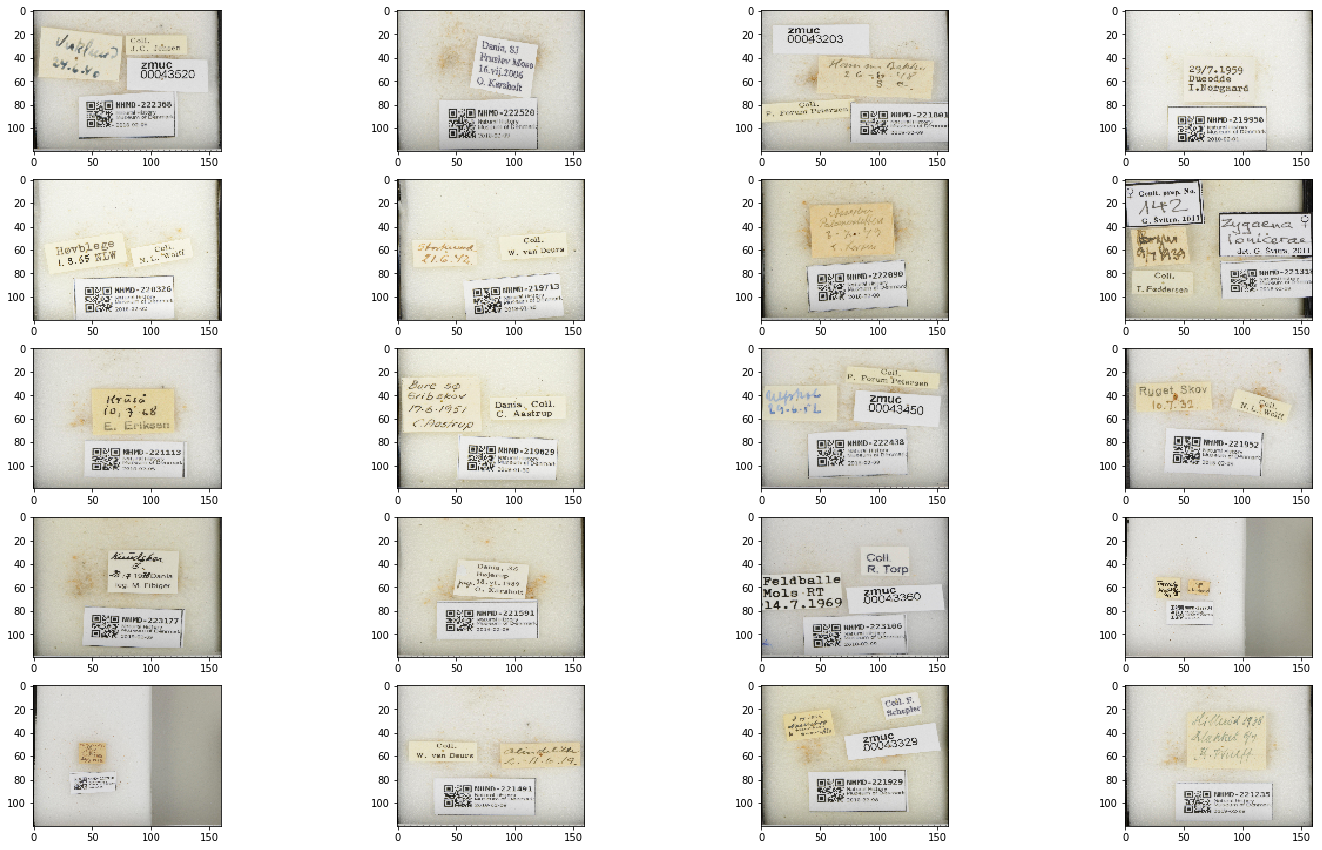

In [4]:
fig=plt.figure(figsize=(25, 15))
columns = 4
rows = 5
n_images = columns*rows


folderGlob = '/home/rob/HWR/datasets/zooniverse/**/Cropped00[2,4].jpg'
fps = glob(folderGlob)

sample = np.random.permutation(fps)

for i in tqdm(range(1, n_images +1)):
    fp = sample[i-1]
    img = cv2.resize(cv2.imread(fp),(160,120))
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [32]:
def detect_text(img, show_image = False):
    # load the input image and grab the image dimensions
    image = img
    orig = image.copy()
    (H, W) = image.shape[:2]
    (H/32,W/32)

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (11*32*4, 7*32*4)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]    

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet('frozen_east_text_detection.pb')

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]


        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.8:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    
    if show_image == True:
        # loop over the bounding boxes
        for (startX, startY, endX, endY) in rects:
            # scale the bounding box coordinates based on the respective
            # ratios

            # draw the bounding box on the image
            cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # show the output image
        plt.figure(figsize=(20,20))
        plt.imshow(orig)
        cv2.waitKey(0)
    
    return rects

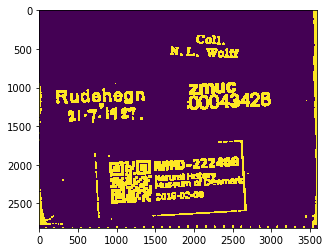

In [7]:

_,th = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((10,10),np.uint8)
d = cv2.dilate(th,kernel,iterations = 2)

plt.imshow(d)


[INFO] loading EAST text detector...
[INFO] text detection took 4.243750 seconds


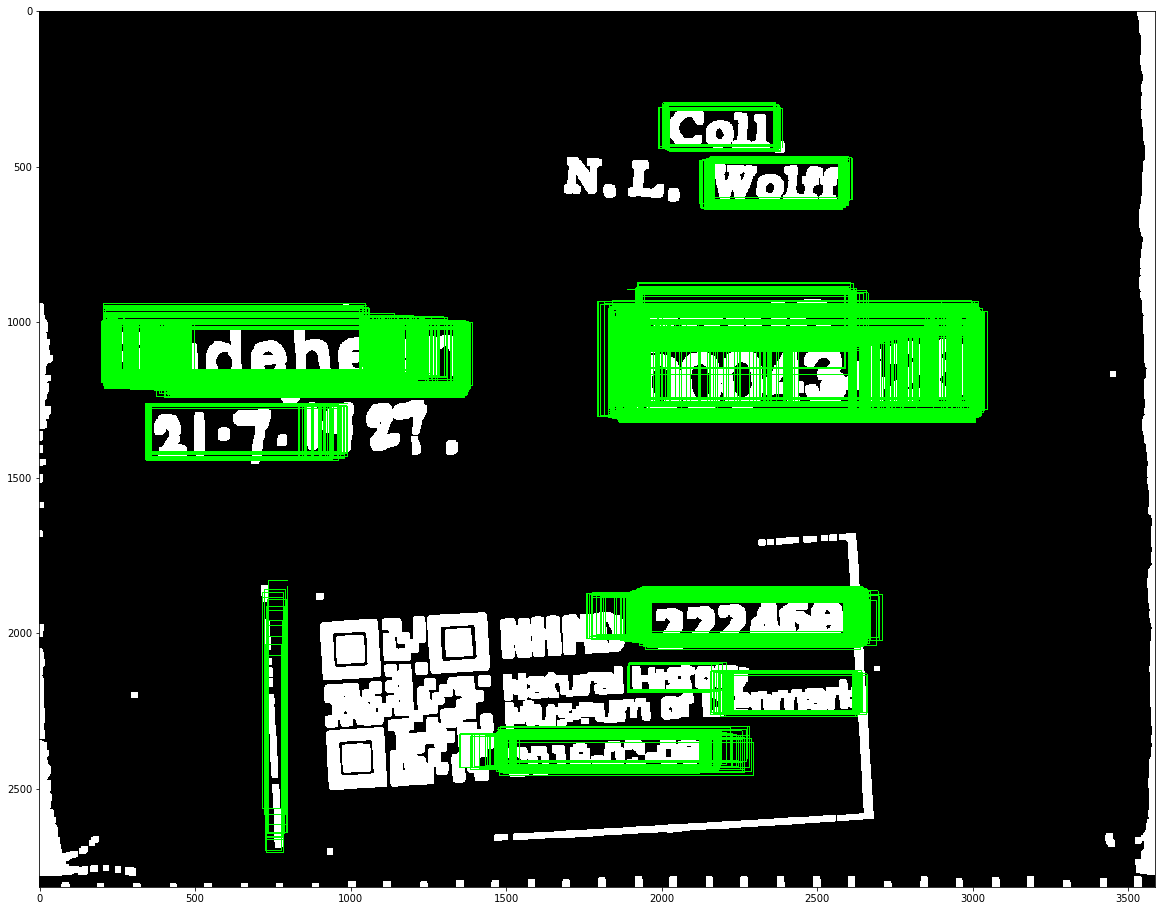

In [8]:
detect_text(cv2.merge((d,d,d)), show_image=True);

In [9]:
show_image = True
# load the input image and grab the image dimensions
image = img
orig = image.copy()
(H, W) = image.shape[:2]
(H/32,W/32)

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (11*32*4, 7*32*4)
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]    

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]


    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.8:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
            
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])


        

[INFO] loading EAST text detector...
[INFO] text detection took 4.290826 seconds


In [12]:
def merge_similar_rectangles(rects, radius=20):
    merged_rects = []
    rects_stack = rects.copy()
    rect_groups = []

    while len(rects_stack):
        rect1 = rects_stack[0]
        new_rect_group = [rect1]
        for j in range(1, len(rects_stack)):
            rect2 = rects_stack[j]
            diff = np.subtract(rect1, rect2)
            if (np.abs(diff) < radius*2).all():
                new_rect_group += [rect2]
        for rect in new_rect_group:
            rects_stack.remove(rect)

        rect_groups += [new_rect_group]

    for group in rect_groups:
        group = np.array(group)
        min_xStart = min(group[:,0])
        max_xStart = max(group[:,0])
        xStart = min_xStart#(min_xStart + max_xStart)//2

        min_xEnd = min(group[:,2])
        max_xEnd = max(group[:,2])
        xEnd = max_xEnd#(min_xEnd + max_xEnd)//2

        min_yStart = min(group[:,1])
        max_yStart = max(group[:,1])
        yStart = min_yStart#(min_yStart + max_yStart)//2

        min_yEnd = min(group[:,3])
        max_yEnd = max(group[:,3])
        yEnd = max_yEnd#(min_yEnd + max_yEnd)//2

        merged_rect = (xStart, yStart, xEnd, yEnd)
        merged_rects += [merged_rect]
    
    return merged_rects

In [26]:
def expand(rect, expansion):
    return (rect[0]-expansion, rect[1]-expansion, rect[2]+expansion, rect[3]+expansion)
def overlapping(rect1, rect2):
    startx1, starty1, endx1, endy1 = rect1
    startx2, starty2, endx2, endy2 = rect2
    if (endx1 < startx2):
        return False
    elif (endx2 < startx1):
        return False
    elif (endy1 < starty2):
        return False
    elif (endy2 < starty1):
        return False
    else:
        return True
        
def merge_overlapping_rectangles(rects, expansion=0):
    rects_stack = rects.copy()
    merged_rects = []
    rect_groups = []

    while len(rects_stack):
        rect1 = rects_stack[0]
        new_rect_group = [rect1]
        for j in range(1, len(rects_stack)):
            rect2 = rects_stack[j]
            #expand rectangle 1 and 2 by 'expand'
            rect1_ex  = expand(rect1, expansion)
            rect2_ex  = expand(rect2, expansion)
            #check if overlapping
            if overlapping(rect1_ex, rect2_ex):
                new_rect_group += [rect2]

        for rect in new_rect_group:
            rects_stack.remove(rect)

        rect_groups += [new_rect_group]

    for group in rect_groups:
        group = np.array(group)
        minx = min(group[:,0])
        maxx = max(group[:,2])
        miny = min(group[:,1])
        maxy = max(group[:,3])

        merged_rects += [(minx, miny, maxx, maxy)]
        
    return merged_rects

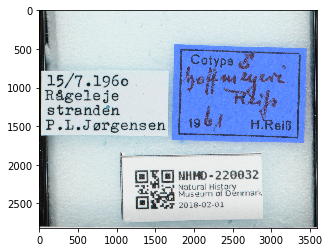

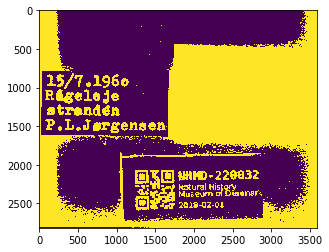

In [56]:
img = cv2.imread(fps[900])#60 is a good example

_,th = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),210,255,cv2.THRESH_BINARY_INV)

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(th)

[INFO] loading EAST text detector...
[INFO] text detection took 4.273343 seconds


-1

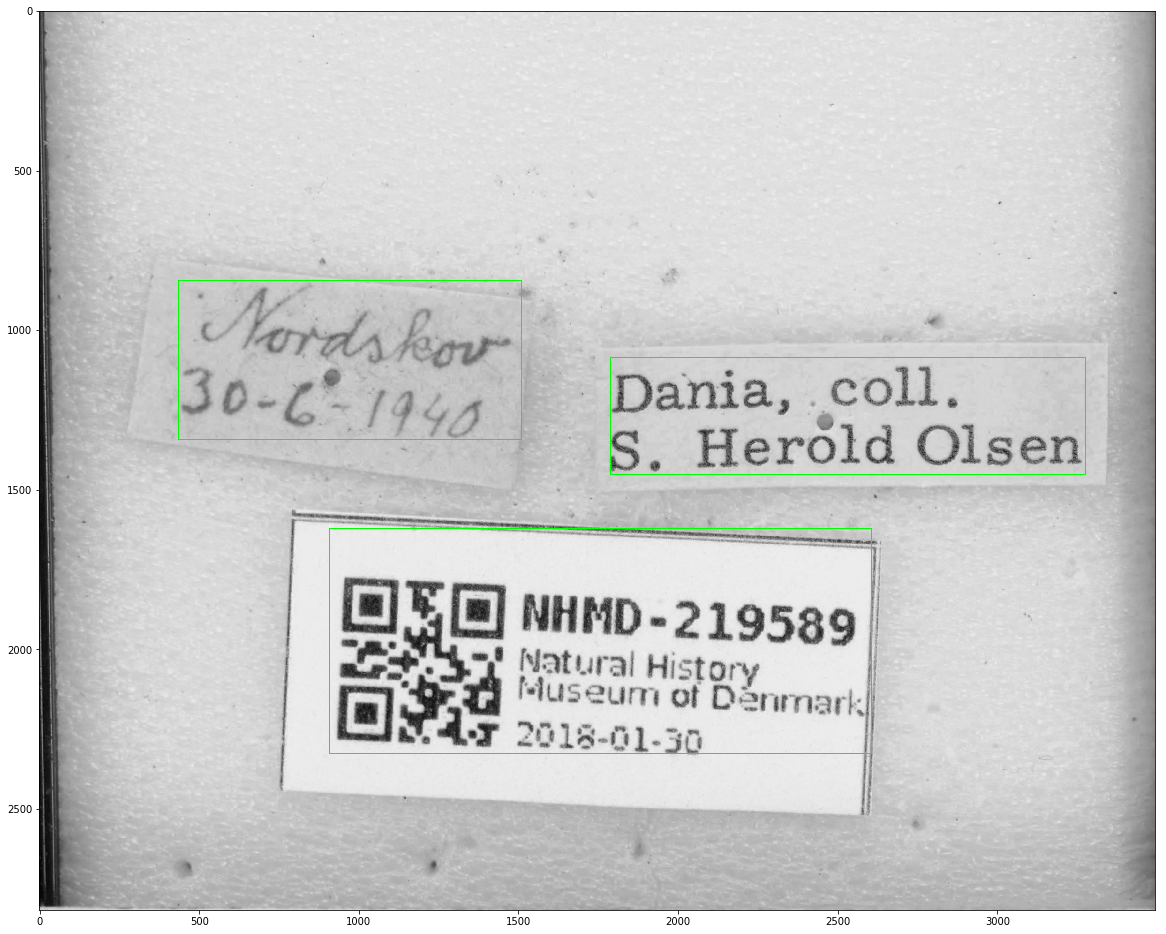

In [59]:
img = cv2.imread(fps[60])
#_,th = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY_INV)
#kernel = np.ones((10,10),np.uint8)
#d = cv2.dilate(th,kernel,iterations = 2)
#img = cv2.merge((d,d,d))

img = img[:,:,0]
img = cv2.merge((img,img,img))
rects = detect_text(img)
merged_rects = merge_similar_rectangles(rects, radius = 100)
merged_rects = merge_overlapping_rectangles(merged_rects, expansion=50)
merged_rects = merge_overlapping_rectangles(merged_rects, expansion=50)
messy = img.copy()
for (startX, startY, endX, endY) in merged_rects:
    cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
plt.figure(figsize=(20,20))
plt.imshow(messy)
cv2.waitKey(0)

[INFO] loading EAST text detector...
[INFO] text detection took 4.250733 seconds
[INFO] loading EAST text detector...
[INFO] text detection took 4.317405 seconds
[INFO] loading EAST text detector...
[INFO] text detection took 4.185889 seconds
[INFO] loading EAST text detector...
[INFO] text detection took 4.288497 seconds
[INFO] loading EAST text detector...
[INFO] text detection took 4.213026 seconds
[INFO] loading EAST text detector...
[INFO] text detection took 4.292837 seconds


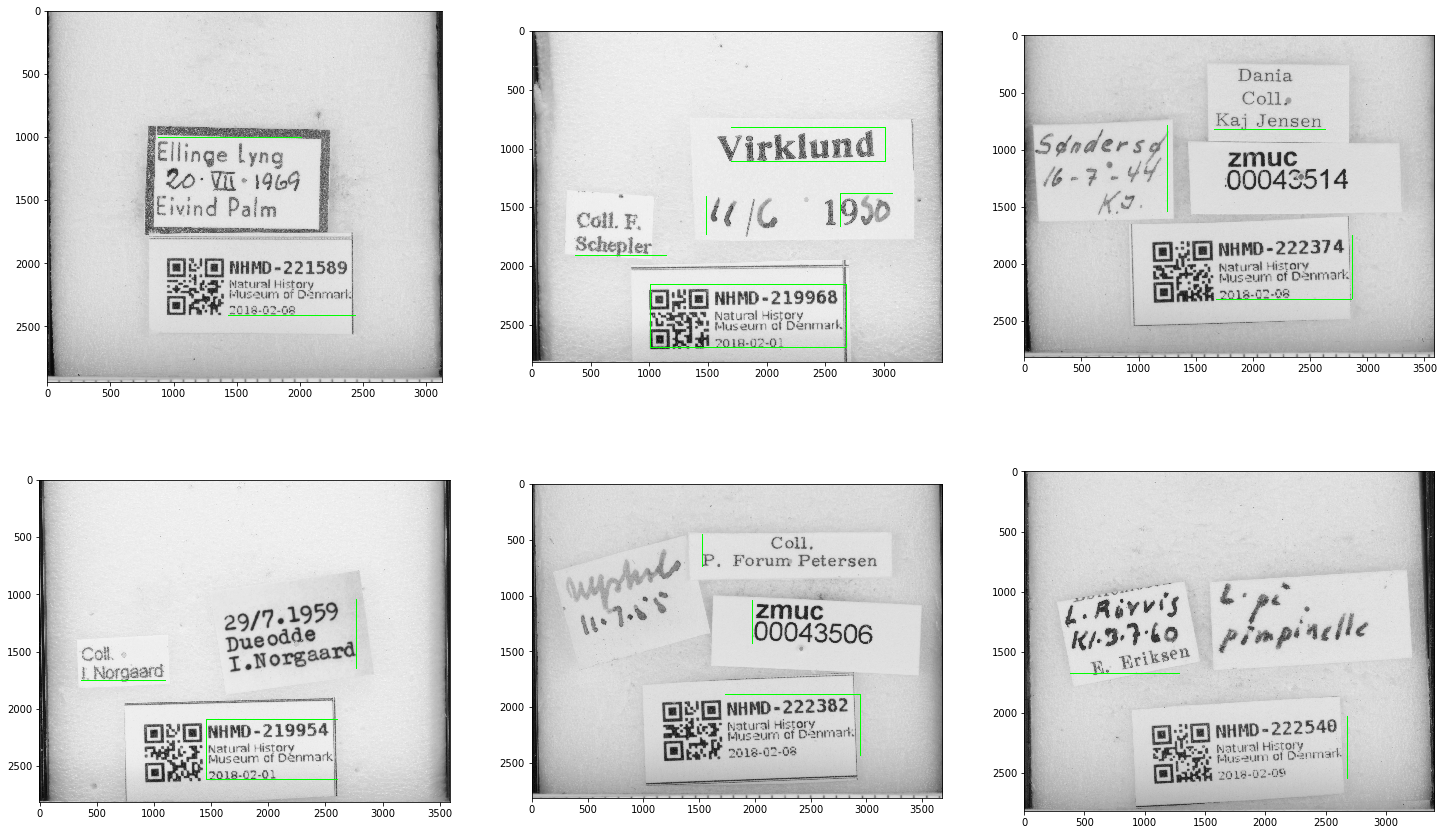

In [64]:
fig=plt.figure(figsize=(25, 15))
columns = 3
rows = 2
n_images = columns*rows


folderGlob = '/home/rob/HWR/datasets/zooniverse/**/Cropped00[2,4].jpg'
fps = glob(folderGlob)

sample = np.random.permutation(fps)

for i in tqdm(range(1, n_images +1)):
    fp = sample[i-1]
    img = cv2.imread(fp)#cv2.resize(cv2.imread(fp),(160*4,120*4))

    img = img[:,:,2]
    img = cv2.merge((img,img,img))
    rects = detect_text(img)
    merged_rects = merge_similar_rectangles(rects, radius = 100)
    merged_rects = merge_overlapping_rectangles(merged_rects, expansion=50)
    merged_rects = merge_overlapping_rectangles(merged_rects, expansion=50)
    messy = img.copy()
    for (startX, startY, endX, endY) in merged_rects:
        cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)

    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(messy, cv2.COLOR_BGR2RGB))
plt.show()


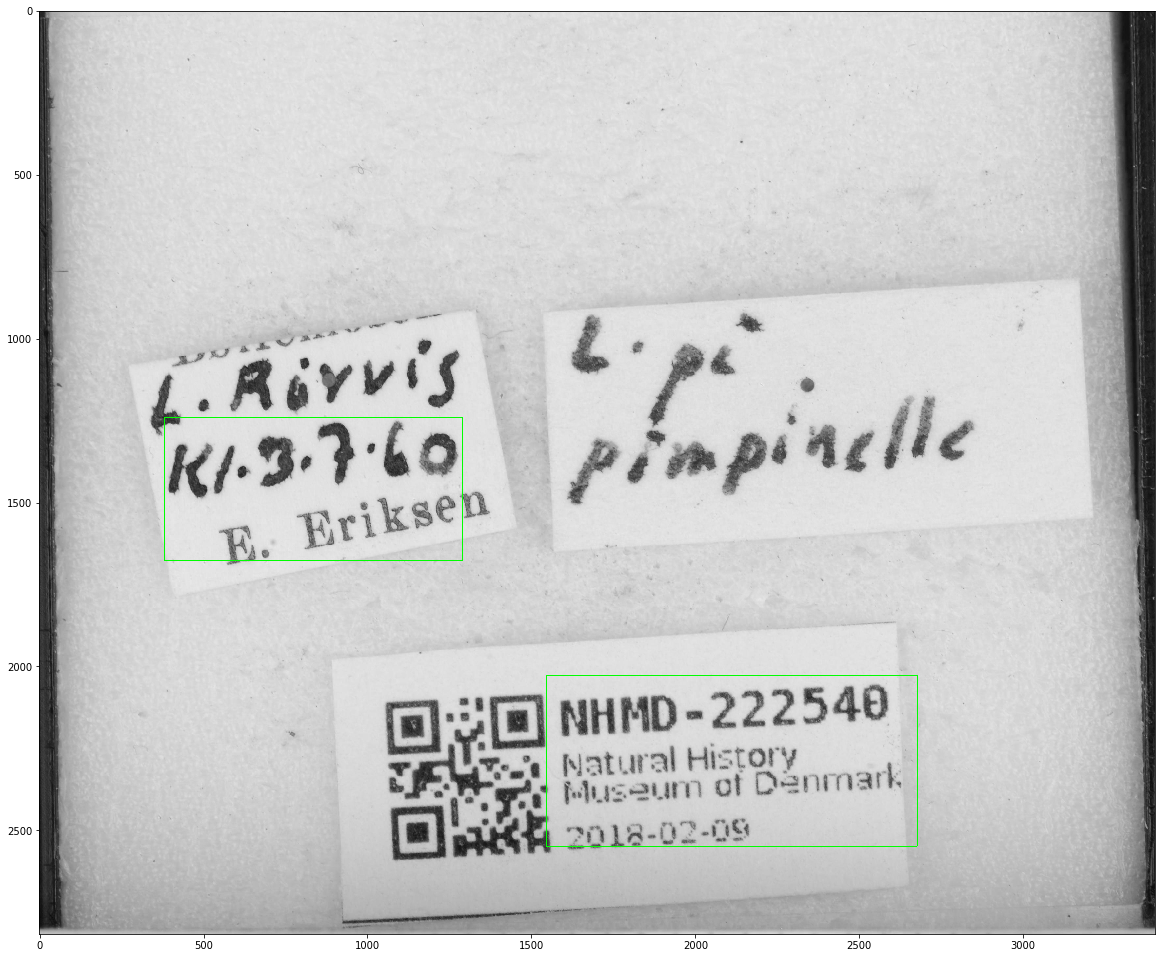

In [66]:
plt.figure(figsize=(20,20))
plt.imshow(messy)